In [1]:
from landlab import RasterModelGrid
from gravel_bedrock_eroder.gravel_bedrock_eroder import GravelBedrockEroder
from landlab.components import FlowAccumulator
from ClastGrading import ClastGrading
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Global parameters
porosity = 0.4                              # [-]
soil_density = 2650                         # [kg/m^3]
initial_sediment_weight_at_node = 100000    # [kg]
n_steps = 500

""" Create grading features with different fragmentation models. 
Fragmentation models are describe by the following string:
      !!   pX-AAA-BBB-CCC-DDD'  !!       
while
X = number of daughter particles
AAA = weight % that *REMAINS* in  parent after fragmentation
BBB / CCC / DDD ... = proportion of daughters '
"""
grading_name = 'p2-0-100'  # ,'p2-10-10-spread'  #,'p2-0-100'

In [3]:
# Create grid
grid = RasterModelGrid((3, 3), xy_spacing=1000.0)
elev = grid.add_zeros("topographic__elevation", at="node")

In [4]:
# Flag for an apriori grain size disribution OR for generating a distribution
known_dist_flag = True

if known_dist_flag:
    mean_grainsize_per_class = [0.002, 0.02, 0.2, 2, 10]  # [0.002, 0.2, 1 ]  # [m]
    init_median_grainsize_at_node = 0.2           # [m]
    n_size_classes = np.size(mean_grainsize_per_class )
    A_factor = 0.001
else:
    init_median_grainsize_at_node = 0.1           # [m]
    n_size_classes = 30
    maxsize = 2
    A_factor = 0.01

In [5]:
# Call ClastGrading component
grading = ClastGrading(
    grid,
    grading_name=grading_name,
    n_size_classes=n_size_classes,
    clast_density=soil_density,
    phi=porosity,
)

In [6]:
if known_dist_flag:
    grading.set_grading_classes(input_sizes_flag=True,
                                meansizes=mean_grainsize_per_class,
                                )
    grading.create_transition_mat(A_factor=A_factor)
    
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True,
    std=1)

else:

    grading.set_grading_classes(maxsize = maxsize)
    grading.create_transion_mat(A_factor=A_factor)
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True, )

In [7]:
grid.at_node['soil__depth']

array([  6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05])

In [8]:
# Call other components 
fa = FlowAccumulator(grid, runoff_rate=10.0)
fa.run_one_step()
eroder = GravelBedrockEroder(
    grid, sediment_porosity = 0.4, abrasion_coefficients = [0.0005]
)

In [9]:
# Boundary conditions
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[5] = grid.BC_NODE_IS_FIXED_VALUE

In [10]:
# Pointers
rock_elev = grid.at_node["bedrock__elevation"]

# save inital weight per grain size
init_weight_per_grainsize = np.copy(grid.at_node['grain__weight'][3,:])

In [11]:
# MAIN LOOP
for _ in range(n_steps ):
    rock_elev[grid.core_nodes] += 1.0
    elev[grid.core_nodes] += 1.0
    fa.run_one_step()
    eroder.run_one_step(10000.0)
    grading.run_one_step()

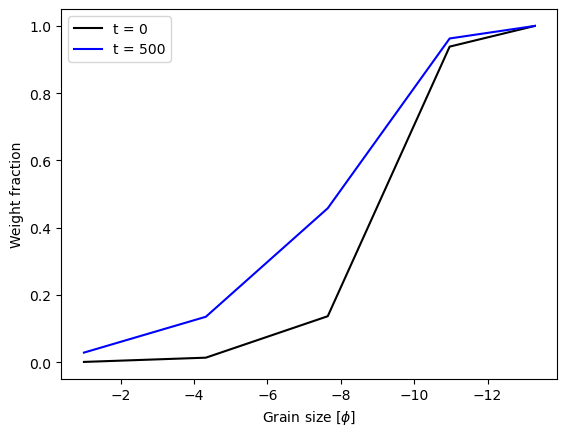

In [12]:
# Figure
total_weight = np.sum(grid.at_node['grain__weight'][3,:])
fig,ax = plt.subplots(1,1)
ax.plot(-np.log2(grading._meansizes*1000),
        np.cumsum(init_weight_per_grainsize)/total_weight,
        color='black',
       label='t = 0')
ax.plot(-np.log2(grading._meansizes*1000),np.cumsum(grid.at_node['grain__weight'][3,:])/total_weight,color='blue',label='t = ' + str(n_steps ))
ax.set_xlabel('Grain size [$\phi$]')
ax.set_ylabel('Weight fraction')
ax.invert_xaxis() # phi scale
ax.legend()
plt.show()

In [48]:
init_weight_per_grainsize

array([  6.77000000e+02,   1.93000000e+02,   2.03000000e+02,
         2.72000000e+02,   3.28000000e+02,   5.23000000e+02,
         6.59000000e+02,   7.68000000e+02,   9.26000000e+02,
         1.35400000e+03,   1.79300000e+03,   2.41500000e+03,
         3.22200000e+03,   4.59800000e+03,   6.26200000e+03,
         8.56000000e+03,   1.12300000e+04,   1.40900000e+04,
         1.56670000e+04,   1.40680000e+04,   8.77900000e+03,
         2.99600000e+03,   4.03000000e+02,   1.40000000e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [37]:
grading.update_sizes()

In [70]:
## Let say you have a transition matrix A.
# A dims are number_of_grain_size_classes X number_of_grain_size_classes
np.shape(grading._A)

(30, 30)

In [107]:
# Each node 
n_of_grainsize_classes = 5

a = np.reshape(
    np.dot(
        grading._A,
          np.swapaxes(
              np.reshape(
                  grid.at_node['grain__weight'],
                                 (grid.shape[0],grid.shape[1],n_of_grainsize_classes))
              ,1,2)
                    ),
              (grid.shape[0]*grid.shape[1],n_of_grainsize_classes)
)


In [125]:
_n_sizes = 5
a = np.moveaxis(np.dot(grading._A , np.swapaxes(
            np.reshape(grid.at_node['grain__weight'], (grid.shape[0],
                                                            grid.shape[1],
                                                            _n_sizes)), 1,
            2)),
                                    0, -1)

In [128]:
np.reshape(a, (grid.shape[0] * grid.shape[1], _n_sizes))

array([[  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.]])

In [129]:
grading._A

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0., -1.]])

In [130]:
grid.at_node['grain__weight']

array([[   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.]])

In [81]:
b = np.moveaxis(a,0,-1)
np.shape(b)

(3, 3, 30)

In [82]:
kk = np.reshape(b,(grid.shape[0]*grid.shape[1],30))

In [83]:
np.shape(k)

(9, 30)

In [84]:
k -kk

array([[  0.00000000e+00,   1.42000000e+02,   1.13000000e+02,
          1.40000000e+02,   5.70000000e+01,   5.70000000e+01,
         -4.00000000e+00,  -7.30000000e+01,  -1.21000000e+02,
         -4.28000000e+02,  -5.77000000e+02,  -8.90000000e+02,
         -1.16700000e+03,  -1.53500000e+03,  -2.33400000e+03,
         -3.08700000e+03,  -2.56100000e+03,  -1.49300000e+03,
          1.65900000e+03,   5.41600000e+03,   5.95800000e+03,
          2.59600000e+03,   4.64000000e+02,   7.90000000e+01,
          7.00000000e+01,   6.90000000e+01,   6.90000000e+01,
          4.20000000e+01,   4.20000000e+01,   4.20000000e+01],
       [ -1.40000000e+02,   2.00000000e+00,  -2.70000000e+01,
          0.00000000e+00,  -8.30000000e+01,  -8.30000000e+01,
         -6.10000000e+01,  -1.30000000e+02,  -1.78000000e+02,
         -3.43000000e+02,  -4.92000000e+02,  -8.05000000e+02,
         -1.08200000e+03,  -1.45000000e+03,  -2.24900000e+03,
         -3.00200000e+03,  -2.47600000e+03,  -1.40800000e+03,
       

In [117]:
grading._A

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0., -1.]])

In [1]:
from landlab import RasterModelGrid
from gravel_bedrock_eroder.gravel_bedrock_eroder import GravelBedrockEroder
from landlab.components import FlowAccumulator
from SoilGrading import SoilGrading
from matplotlib import pyplot as plt
import numpy as np

In [2]:
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
soil_grading = SoilGrading(grid)

0.002
[ 0.00513121  0.00590167  0.0127623  ...,  0.01329234  0.00654097
  0.01741003]


In [3]:
grid.at_node['soil__depth']

array([ 1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667,
        1.66666667,  1.66666667,  1.66666667,  1.66666667])

In [4]:
grid.at_node['median_size__weight']

array([ 0.0056498,  0.0056498,  0.0056498,  0.0056498,  0.0056498,
        0.0056498,  0.0056498,  0.0056498,  0.0056498])

In [5]:
g0 = np.copy(grid.at_node['grains__weight'][grid.nodes][1,1])

In [6]:
for _ in range(1000):
    soil_grading.run_one_step()

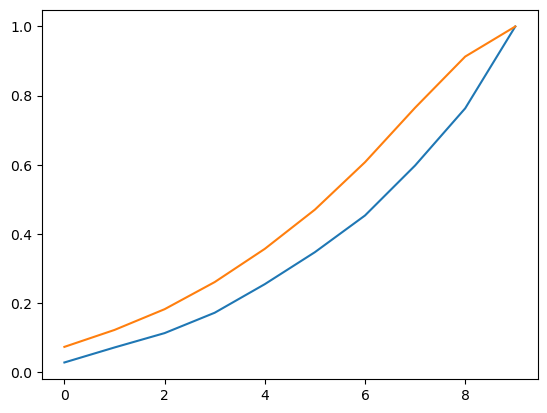

In [7]:
gt = np.copy(grid.at_node['grains__weight'][grid.nodes][1,1])
plt.plot(np.cumsum(g0/np.sum(g0)))
plt.plot(np.cumsum(gt/np.sum(gt)))

In [14]:
soil_grading.create_dist(is_bedrock_distribution_flag=True, median_size = 2)

2
[ 0.00902899  0.0099114   0.00537375 ...,  0.01195679  0.00682323
  0.01556402]


In [15]:
grid.at_node['bed_grains__proportions'][2]

array([ 0.02603774,  0.03886792,  0.05018868,  0.05849057,  0.06679245,
        0.08075472,  0.11245283,  0.14301887,  0.18943396,  0.23396226])

In [30]:
soil_grading._std

0.6

In [53]:
import scipy.stats as stats

median_size = 100000
lower= 0.001
upper = 0.01
std = median_size*0.001
b = stats.truncnorm(
            (lower - median_size) / std, (upper - median_size) / std, loc = median_size, scale = std)

In [54]:
b = b.rvs(2000)

In [55]:
np.histogram(b, np.insert(soil_grading._upperlims, 0, 0))[0]

array([310, 148, 170, 235, 292, 391, 454,   0,   0,   0])

In [59]:
median_size

100000

In [30]:
soil_grading._upperlims

array([ 0.0025    ,  0.0031498 ,  0.0039685 ,  0.005     ,  0.00629961,
        0.00793701,  0.01      ,  0.01259921,  0.01587401,  0.02      ])